In [4]:
%matplotlib notebook

# 6章 学習に関するテクニック

ニューラルネットワークの学習において重要となる以下の内容について学ぶ．

* 最適な重みパラメータを探索する最適化手法
* 重みパラメータの初期値
* ハイパーパラメータの設定方法
* 正則化手法（Weight decay Dropout）
* Batch Normalization

## 6.1 パラメータの更新

ニューラルネットワークの学習の目的: 損失関数の値をできるだけ小さくするパラメータを見つける == 最適化

確率的勾配降下法（stochastic gradient descent, SGD）の欠点を指摘し，別の最適化手法を紹介する．

### 6.1.2 SGD

式（6.1）に示すように，SGDは勾配方向へある一定の距離だけ進む．

In [1]:
#######################
# common/optimizer.py #
#######################

class SGD:

    """確率的勾配降下法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
    
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


### 6.1.3 SGDの欠点

関数の形状が等方的でないと非効率な経路で探索することになる．

<IPython.core.display.Javascript object>


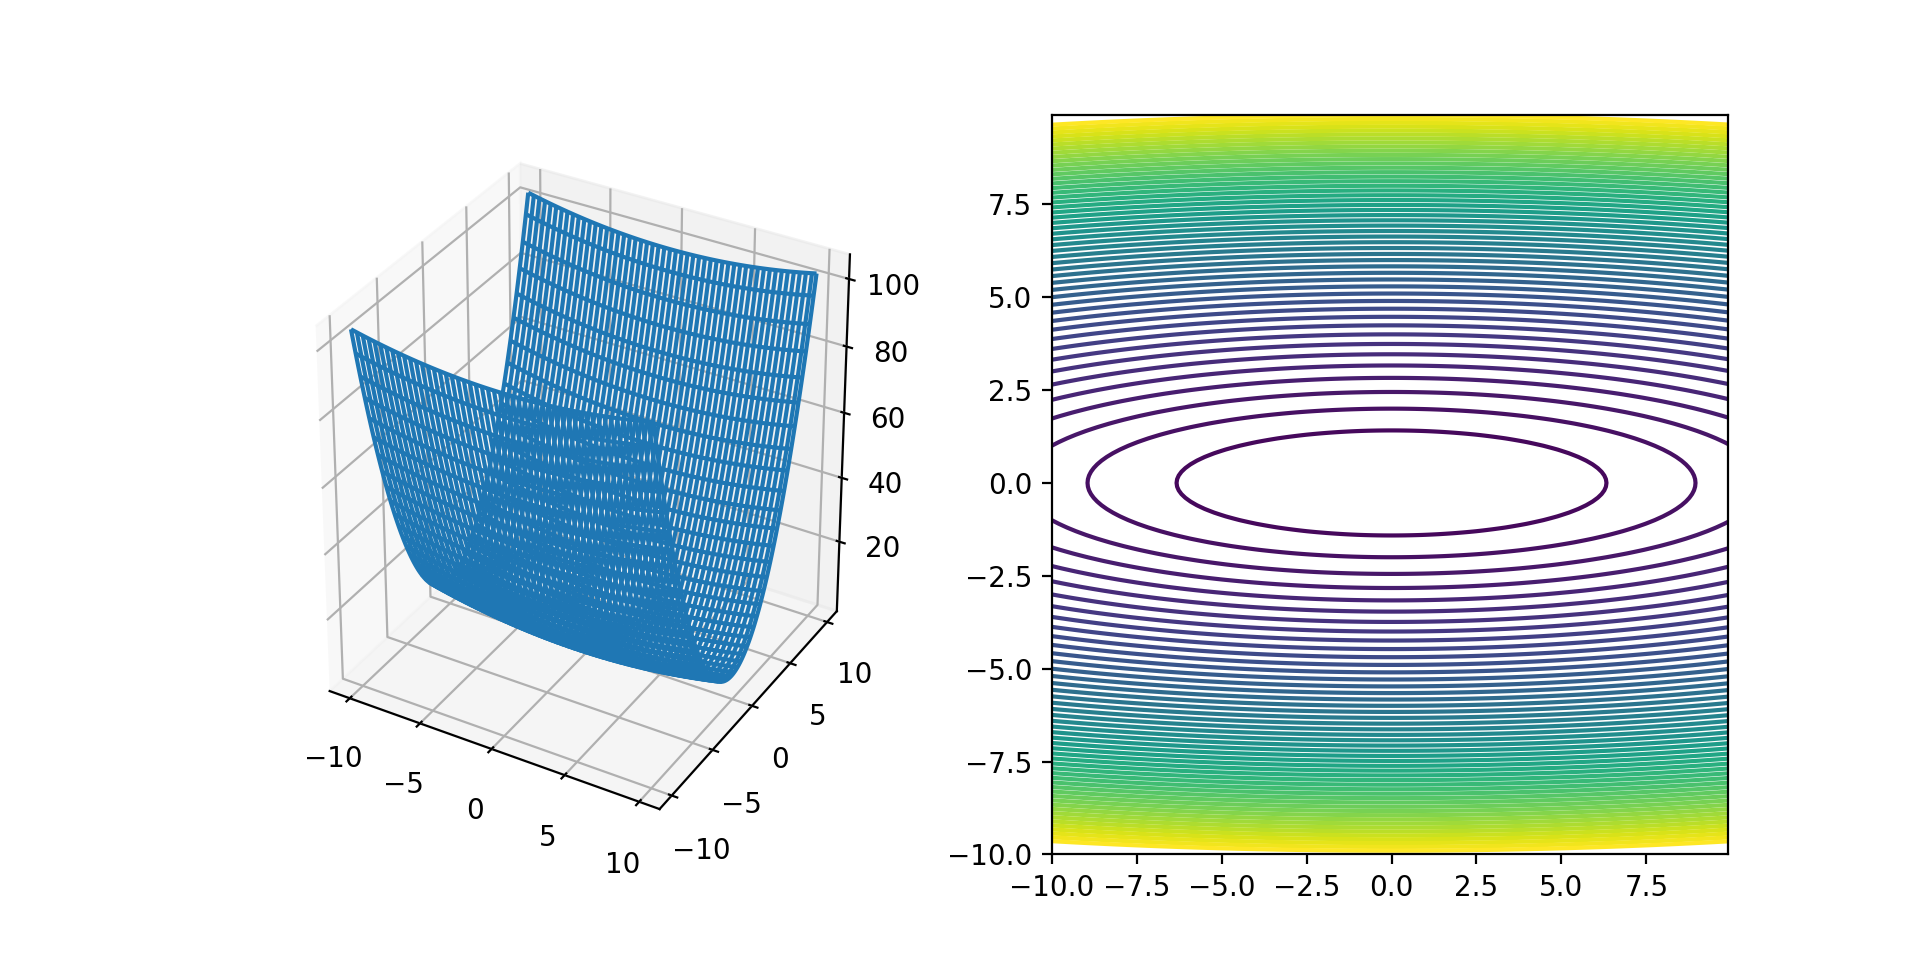

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(x, y)
Z = 1 / 20 * np.power(X,2) + np.power(Y,2)

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_wireframe(X,Y,Z)

ax = fig.add_subplot(1, 2, 2)
ax.contour(X, Y, Z, range(0, 100, 2))
plt.show()

In [3]:
def plot_optimizer(optimizer, params, n_iter=30):
    X, Y = np.meshgrid(np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1))
    Z = 1 / 20 * np.power(X,2) + np.power(Y,2)
    def grads(params):
        g = {}
        g['x'] = 1.0 / 10 * params['x']
        g['y'] = 2 * params['y']
        return g
    x = [params['x']]
    y = [params['y']]
    for i in range(n_iter):
        optimizer.update(params, grads(params))
        x.append(params['x'])
        y.append(params['y'])
    plt.figure()
    plt.contour(X, Y, Z, range(0, 20, 2))
    plt.plot(x, y, linestyle='-', marker='o')
    plt.show()

<IPython.core.display.Javascript object>


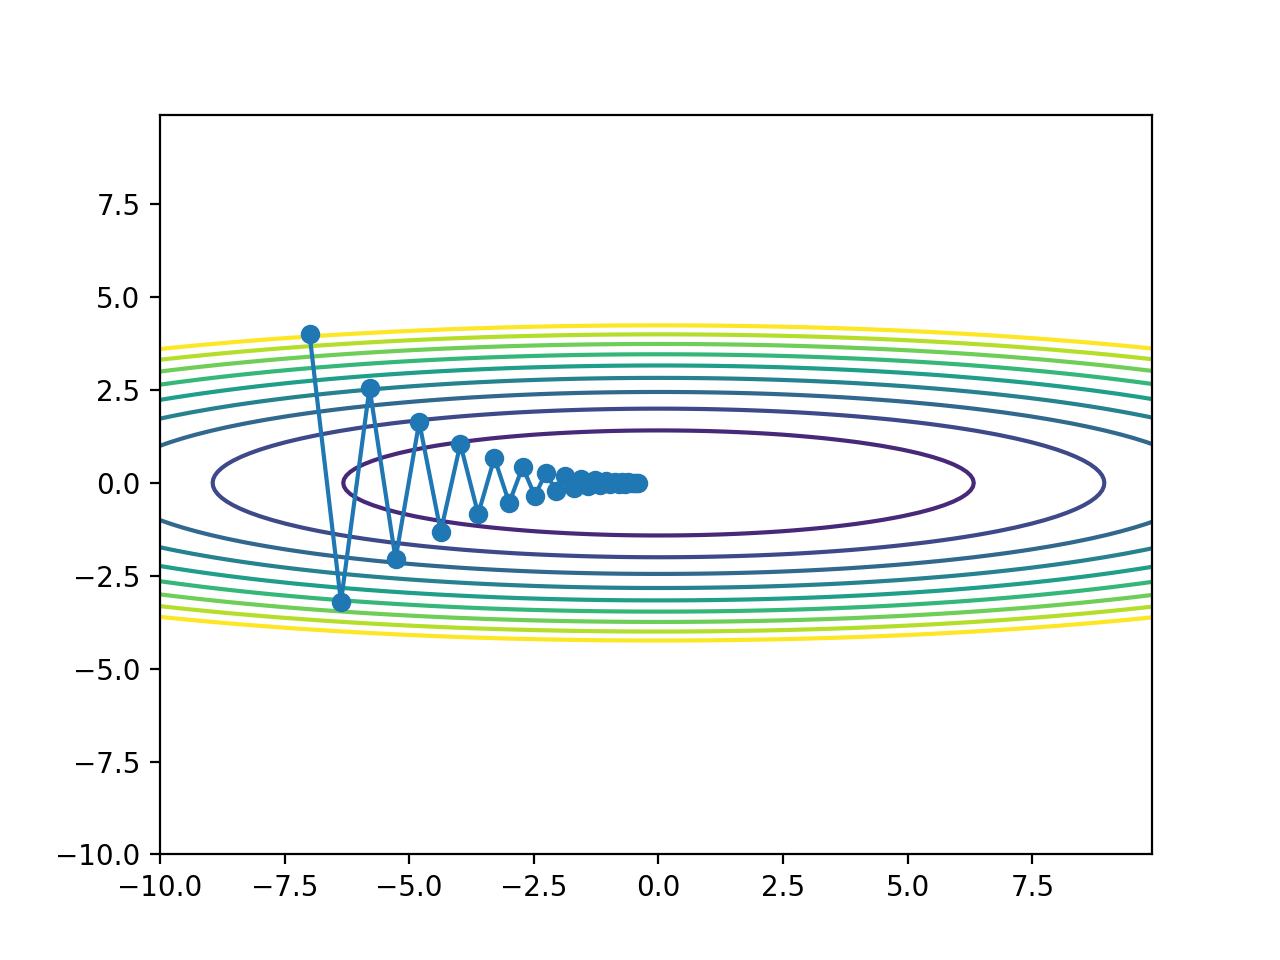

In [4]:
plot_optimizer(SGD(0.9), {'x': -7, 'y': 4})

### 6.1.4 Momentum

式（6.3）および式（6.4）で示すようにα**v**という項が加えられている．
αは (0, 1) の値を取り、物体が何も力を受けないときに徐々に減速するための役割を担う．

In [5]:
#######################
# common/optimizer.py #
#######################


class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


<IPython.core.display.Javascript object>


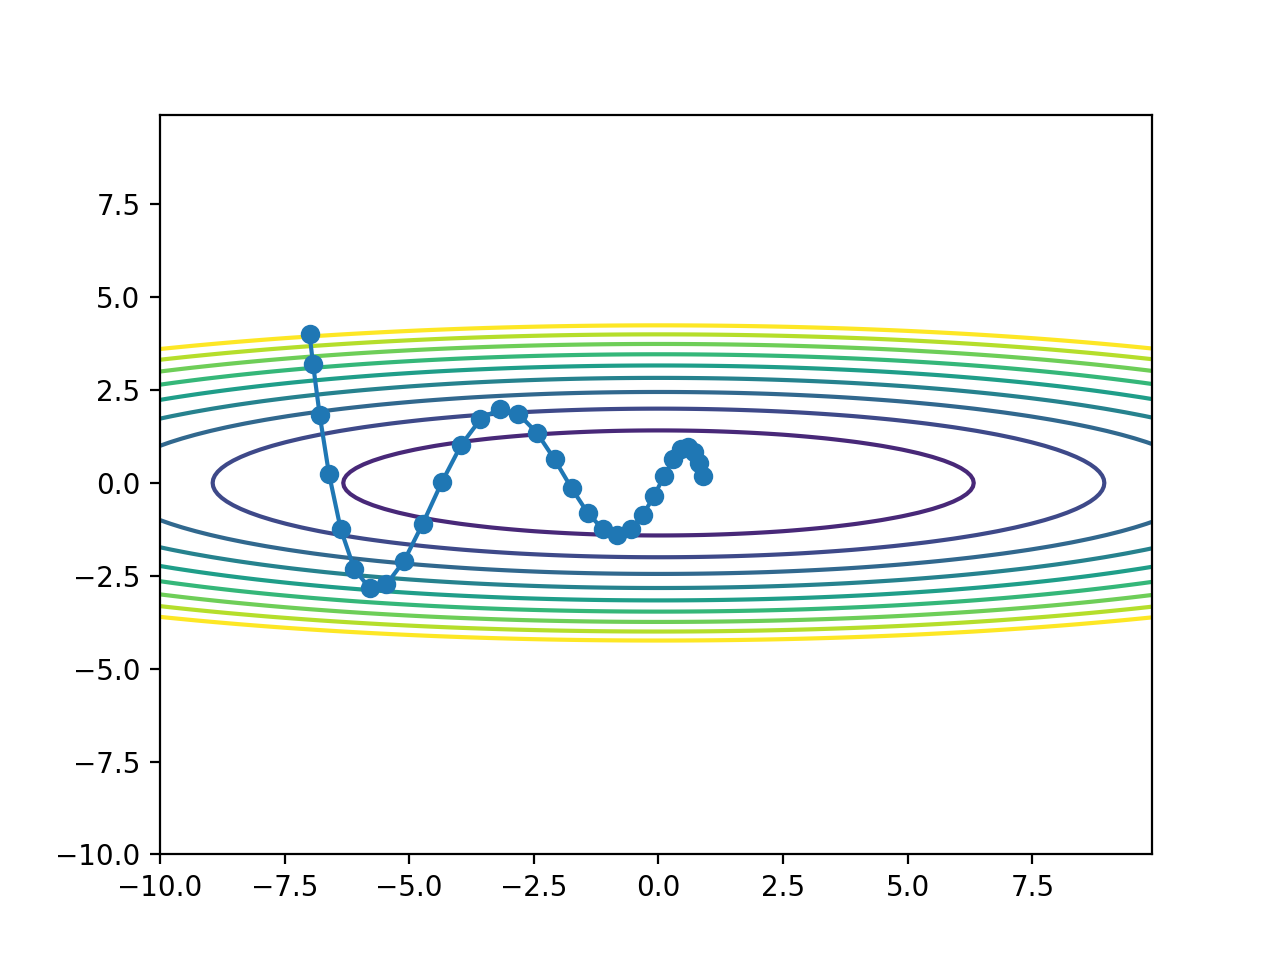

In [6]:
plot_optimizer(Momentum(0.1), {'x': -7, 'y': 4})

### 6.1.5 AdaGrad

式（6.5）および式（6.6）に示すとおり，各パラメータの勾配を継時的な勾配二乗値の和（**h**）の平方根で割ることで学習係数が減衰するよう調整する．

In [14]:
#######################
# common/optimizer.py #
#######################

class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] = np.add(self.h[key], grads[key] * grads[key])
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


<IPython.core.display.Javascript object>


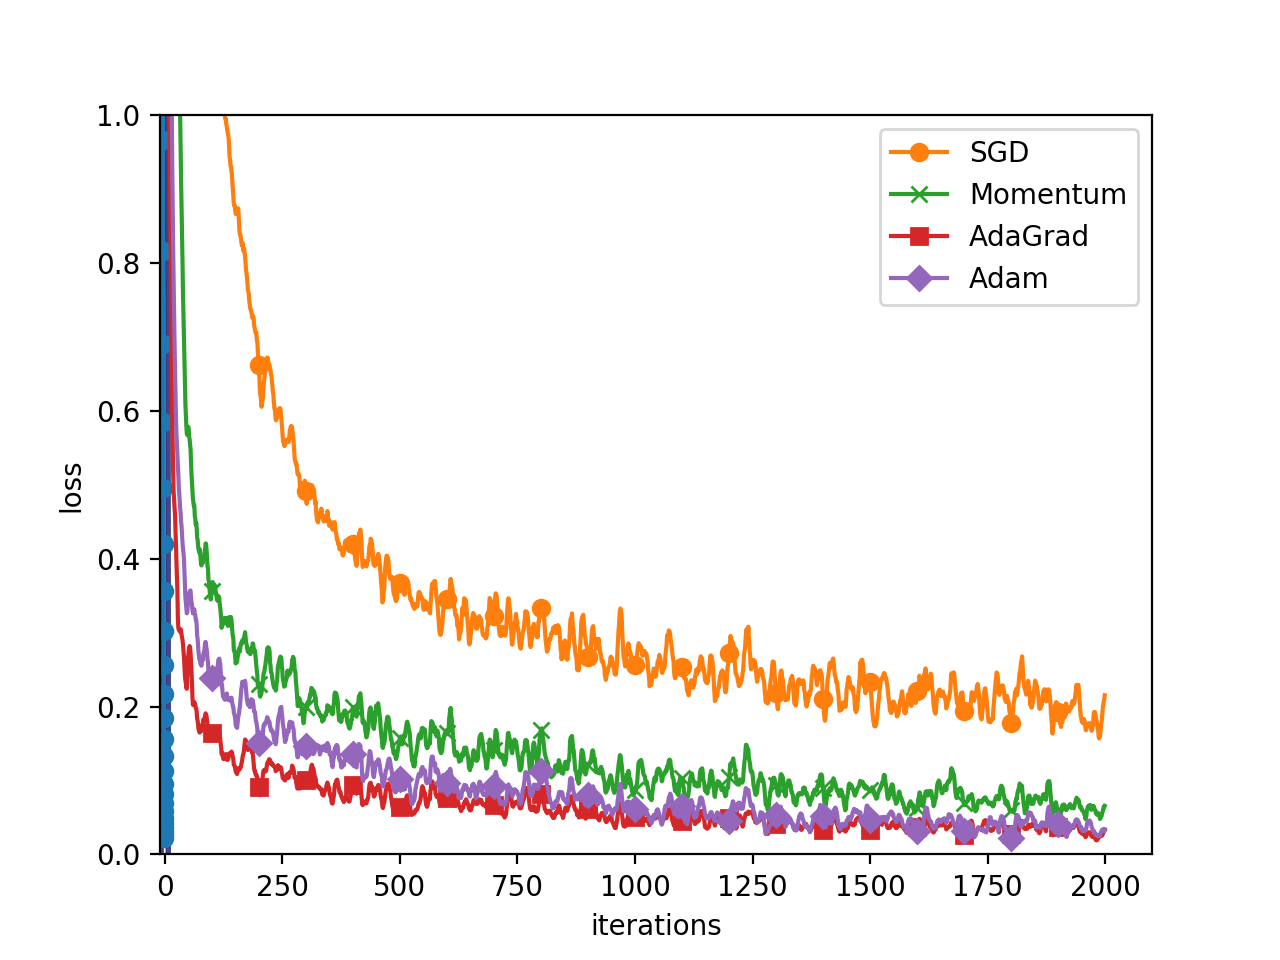

In [15]:
plot_optimizer(AdaGrad(1), {'x': -7, 'y': 4})

### 6.1.6 Adam

MomentumとAdaGradの融合

In [9]:
#######################
# common/optimizer.py #
#######################

class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] = np.add(self.m[key], (1 - self.beta1) * (grads[key] - self.m[key]))
            self.v[key] = np.add(self.v[key], (1 - self.beta2) * (grads[key]**2 - self.v[key]))
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

<IPython.core.display.Javascript object>


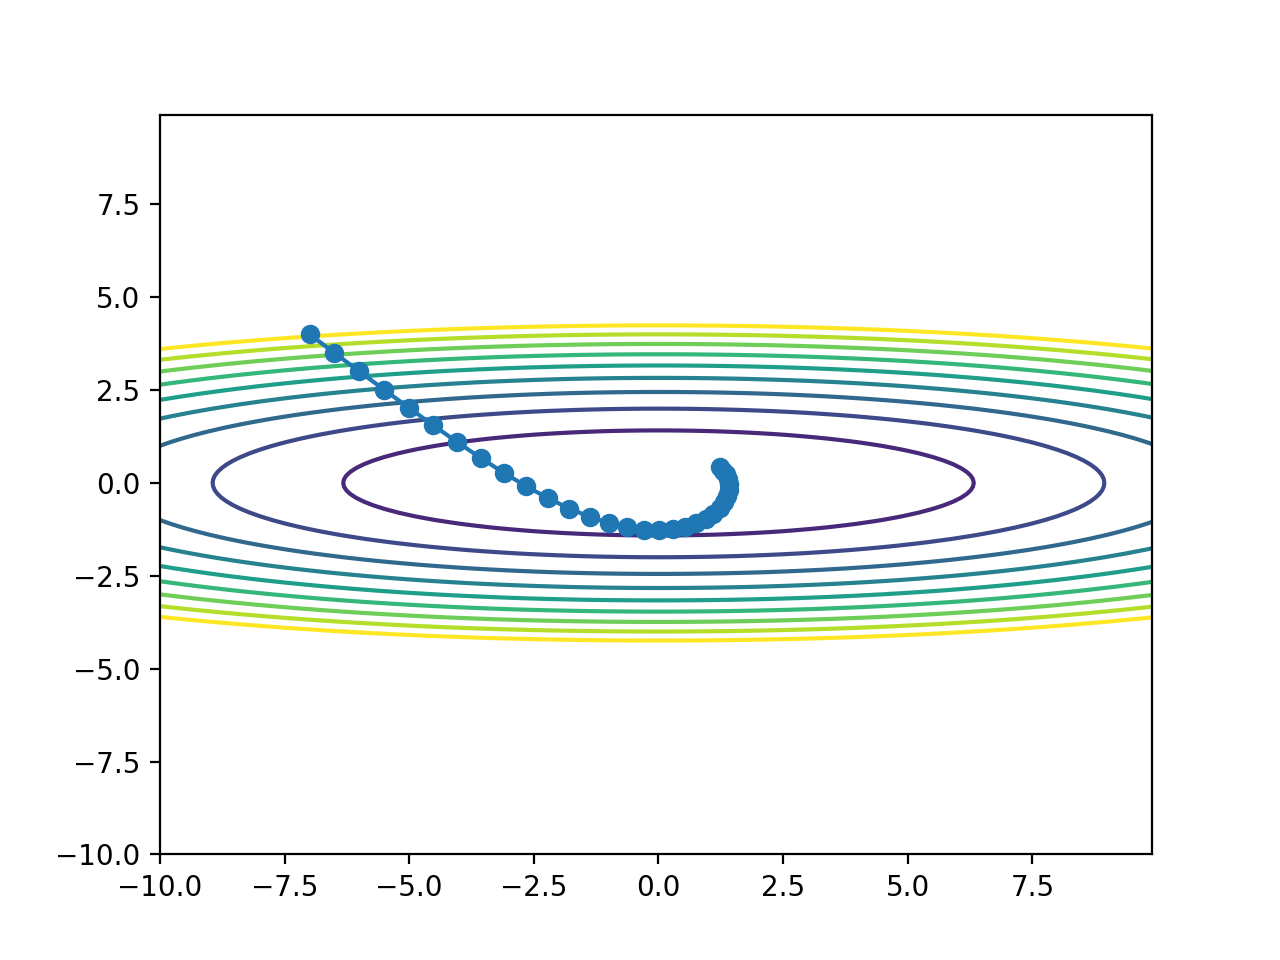

In [10]:
plot_optimizer(Adam(0.5), {'x': -7, 'y': 4})

In [16]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

===========iteration:0===========
SGD:2.29343769201
Momentum:2.33808350862
AdaGrad:2.48726868312
Adam:2.15943629607
===========iteration:100===========
SGD:1.27308250491
Momentum:0.301439154464
AdaGrad:0.155297589461
Adam:0.161091031637
===========iteration:200===========
SGD:0.734117721602
Momentum:0.221001867668
AdaGrad:0.120659539872
Adam:0.16250180741
===========iteration:300===========
SGD:0.503708933944
Momentum:0.182704813036
AdaGrad:0.0712472441826
Adam:0.111867942528
===========iteration:400===========
SGD:0.399627489579
Momentum:0.147647485792
AdaGrad:0.041613957376
Adam:0.08209429645
===========iteration:500===========
SGD:0.444108236531
Momentum:0.162319475648
AdaGrad:0.0579851645
Adam:0.0948572824325
===========iteration:600===========
SGD:0.256384892328
Momentum:0.103662966457
AdaGrad:0.0541841406379
Adam:0.0649653828584
===========iteration:700===========
SGD:0.305960649092
Momentum:0.167748443393
AdaGrad:0.0778188848313
Adam:0.101430603267
===========iteration:800======

## 6.2 重みの初期値

### 6.2.1 重みの初期値を0にする？

重みの更新が均一になりよくない．

### 6.2.2 隠れ層のアクティベーション分布

様々な初期値で隠れ層のアクティベーション分布を確認する

In [34]:
############################################
# ch06/weight_init_activation_histogram.py #
############################################

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)


# ヒストグラムを描画
def plot_histograms(activations):
    plt.figure()
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
#         plt.xlim(0.1, 1)
#         plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()


def hidden_layer_activations(weight_scale=1, activation_function='sigmoid'):
    input_data = np.random.randn(1000, 100)  # 1000個のデータ
    node_num = 100  # 各隠れ層のノード（ニューロン）の数
    hidden_layer_size = 5  # 隠れ層が5層
    activations = {}  # ここにアクティベーションの結果を格納する

    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        # 初期値の値をいろいろ変えて実験しよう！
        w = np.random.randn(node_num, node_num) * weight_scale


        a = np.dot(x, w)


        # 活性化関数の種類も変えて実験しよう！
        if activation_function is 'sigmoid':
            z = sigmoid(a)
        elif activation_function is 'ReLU':
            z = ReLU(a)
        elif activation_function is 'tanh':
            z = tanh(a)
        else:
            print("activation function is invalid")
            return

        activations[i] = z

    plot_histograms(activations)


<IPython.core.display.Javascript object>


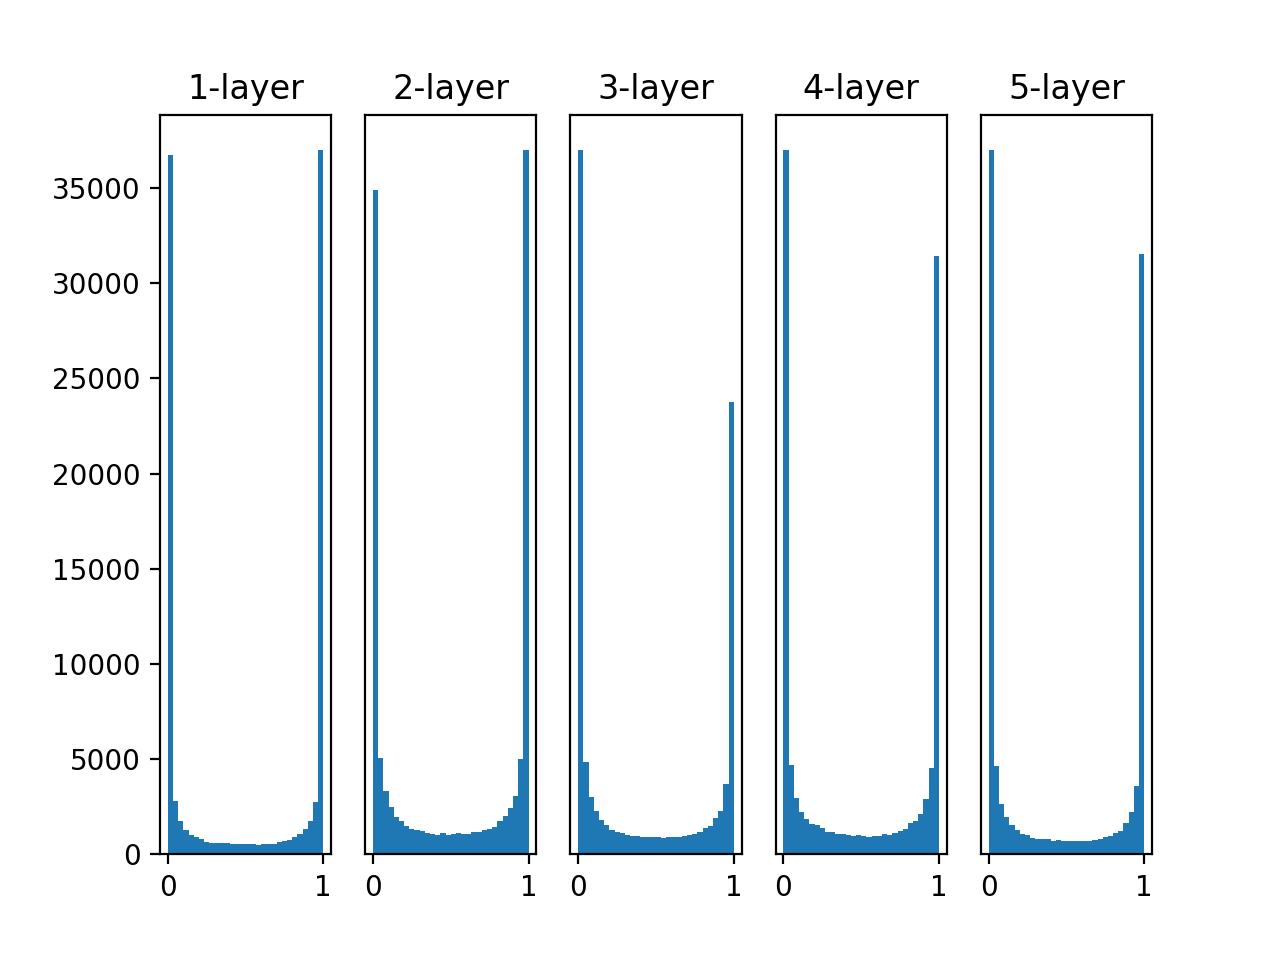

In [35]:
hidden_layer_activations(1)

<IPython.core.display.Javascript object>


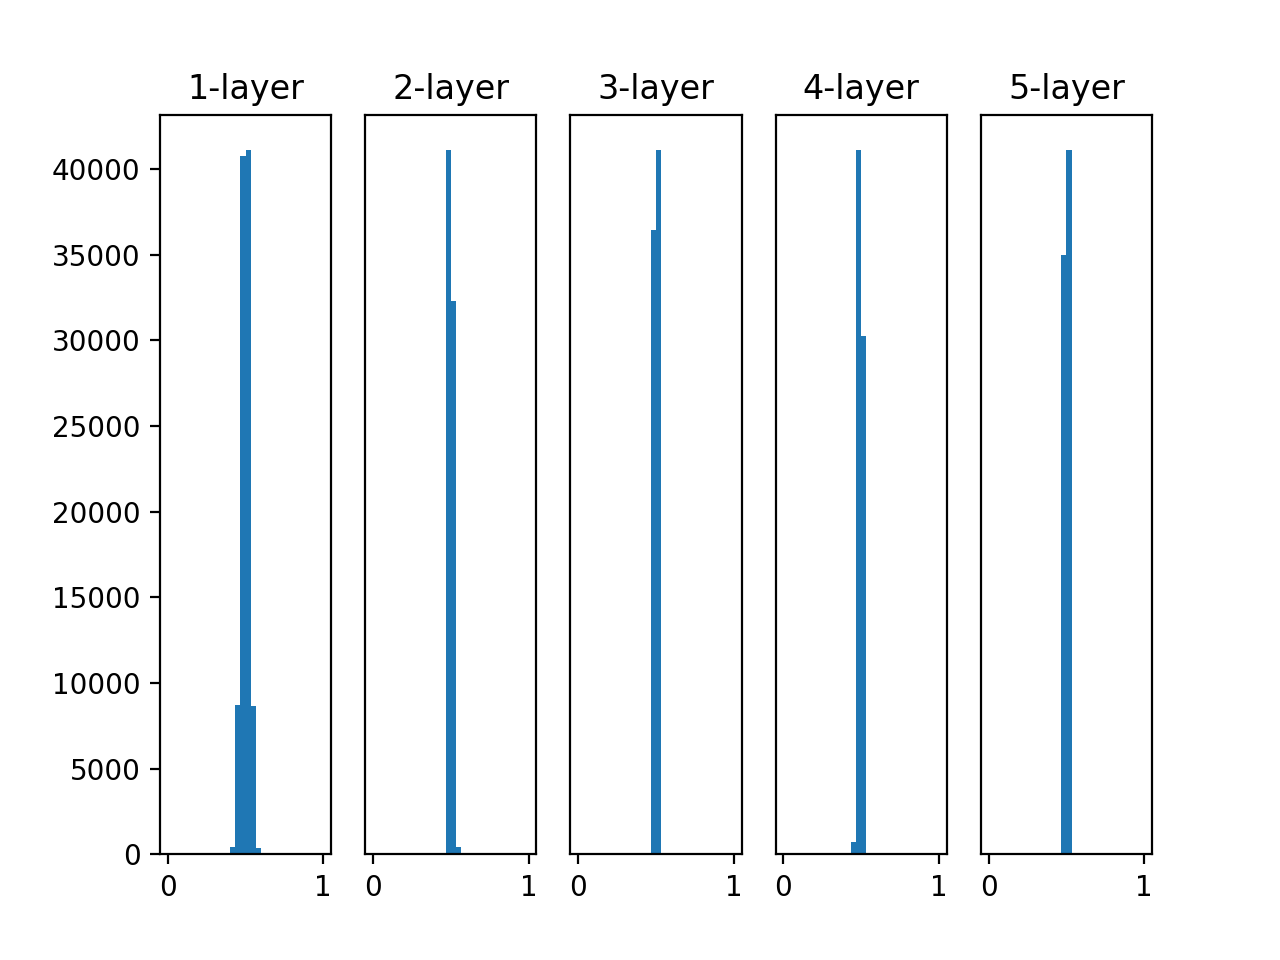

In [36]:
hidden_layer_activations(0.01)

<IPython.core.display.Javascript object>


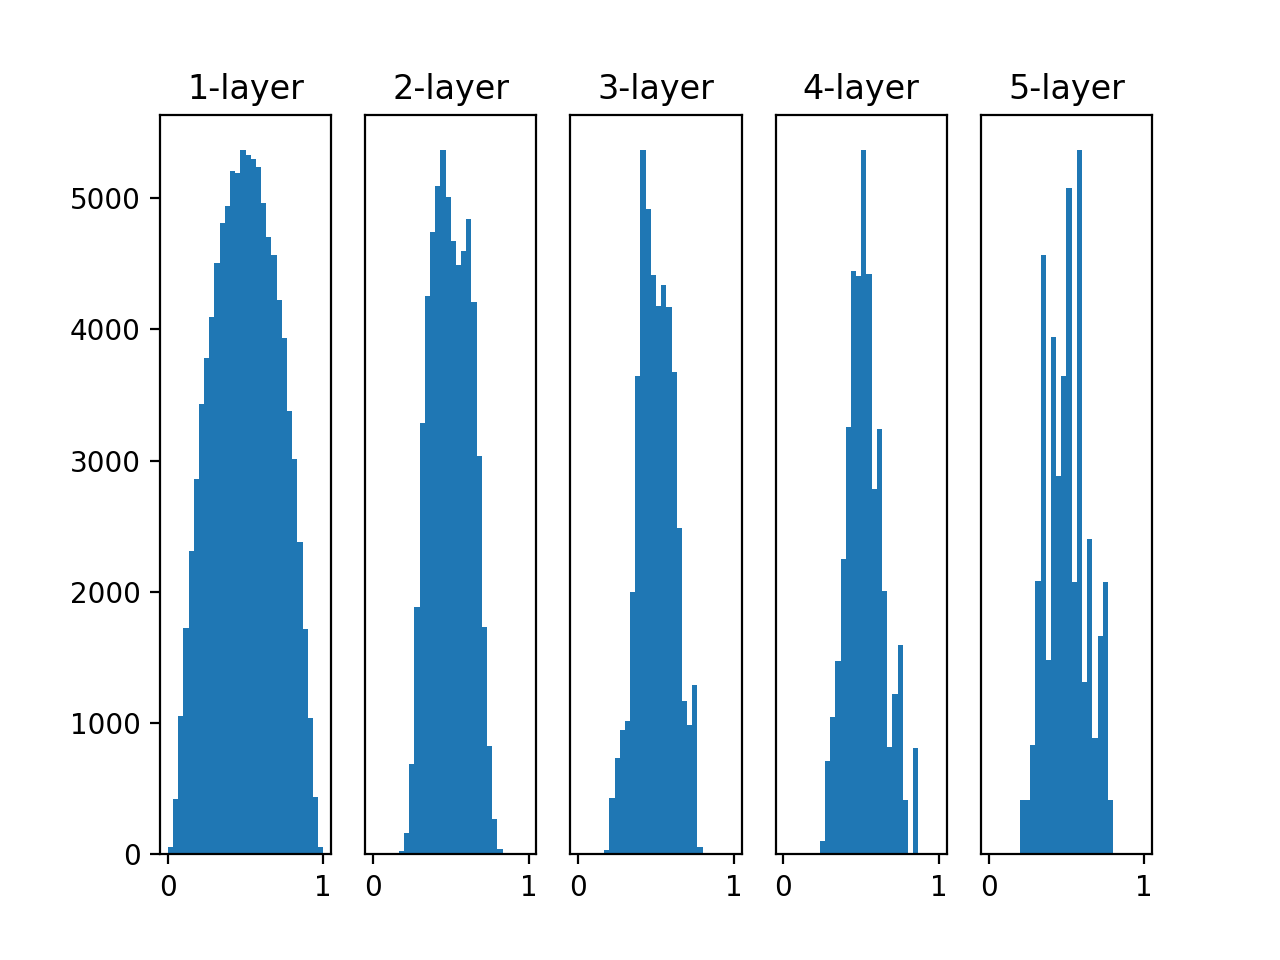

In [37]:
hidden_layer_activations(1/np.sqrt(100))

<IPython.core.display.Javascript object>


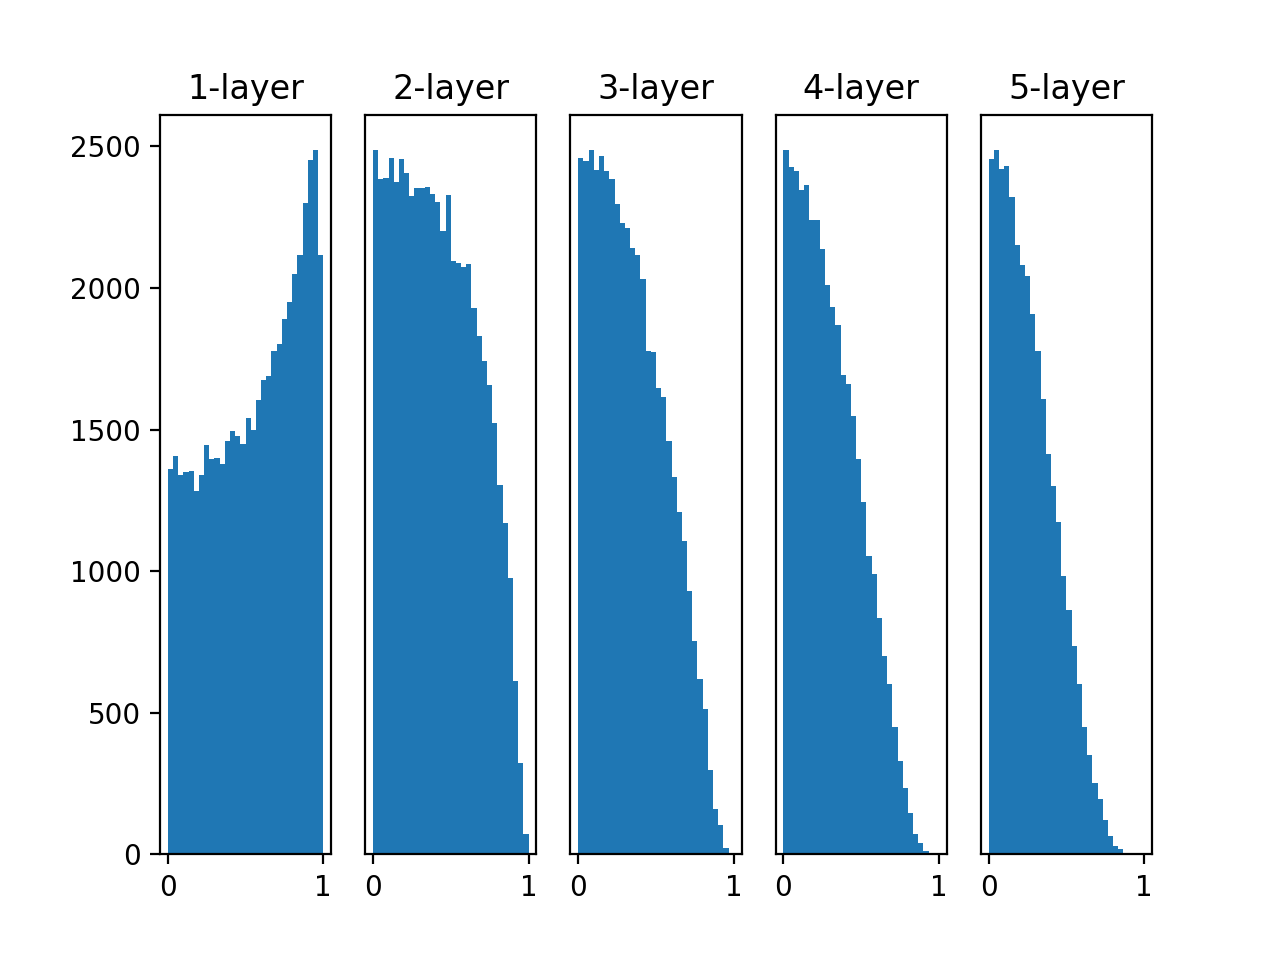

In [38]:
hidden_layer_activations(1/np.sqrt(100), 'tanh')

<IPython.core.display.Javascript object>


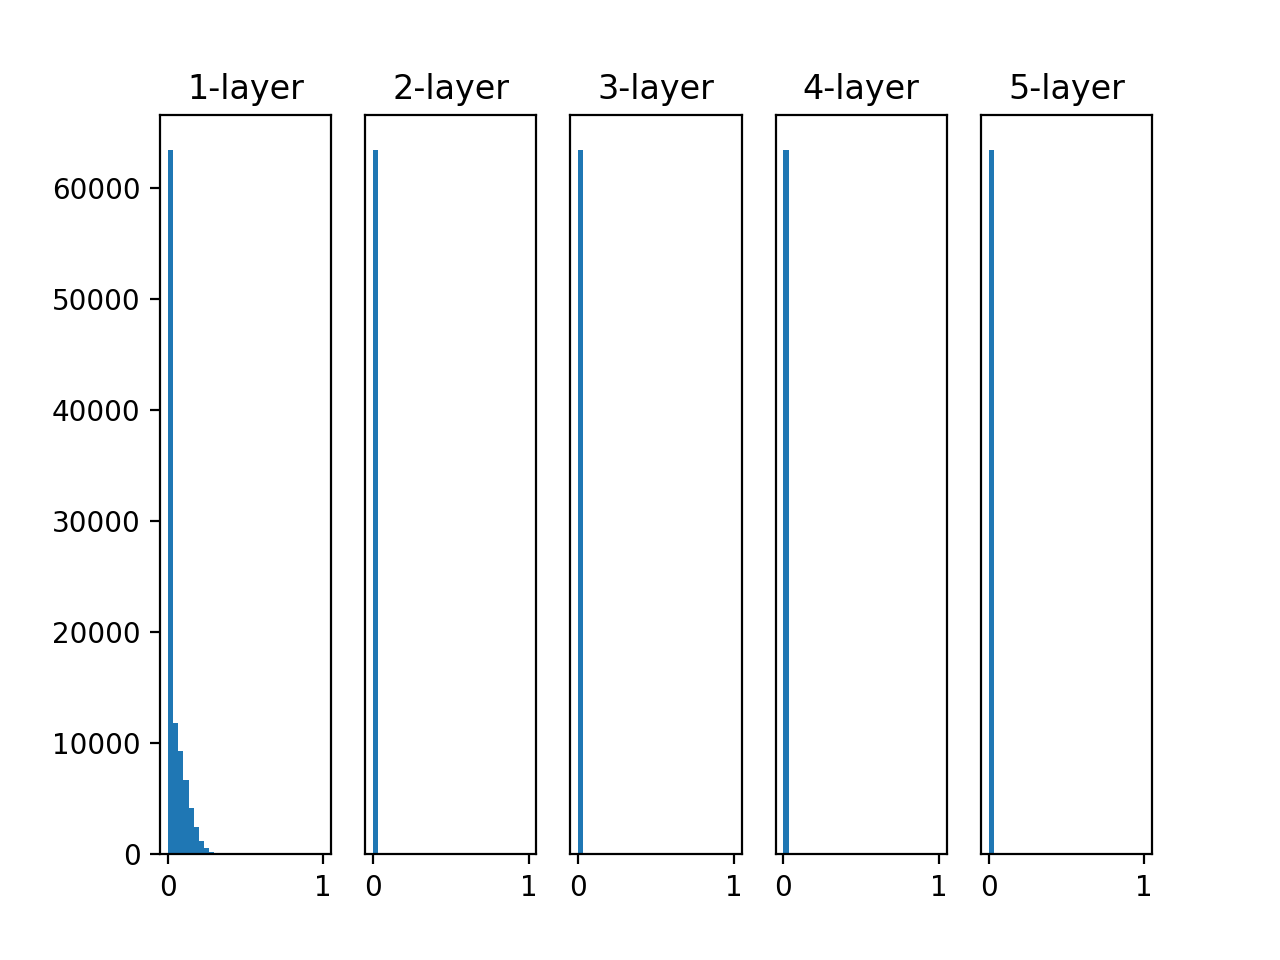

In [39]:
hidden_layer_activations(0.01, 'ReLU')

<IPython.core.display.Javascript object>


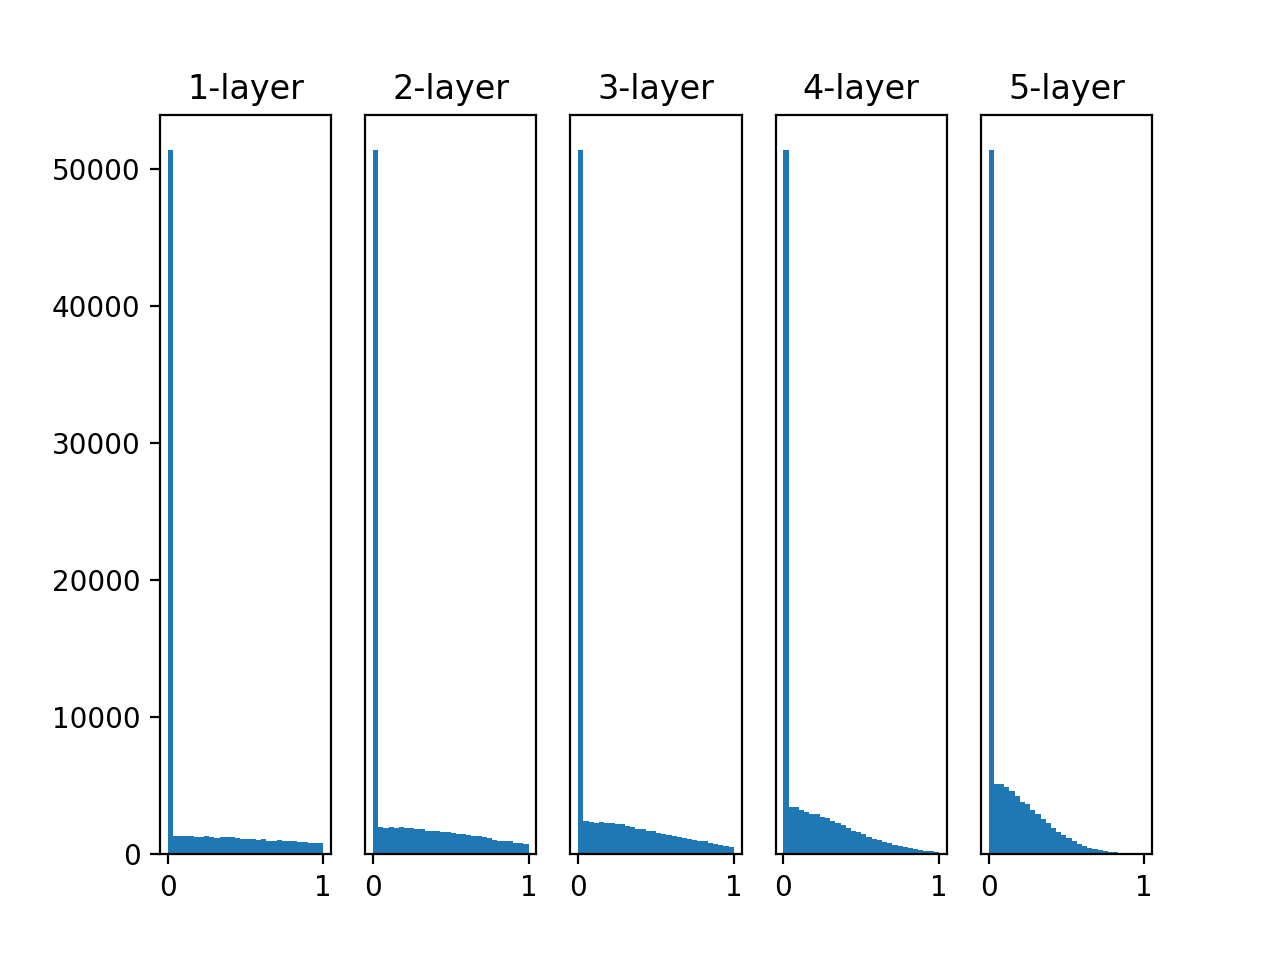

In [40]:
hidden_layer_activations(1/np.sqrt(100), 'ReLU')

<IPython.core.display.Javascript object>


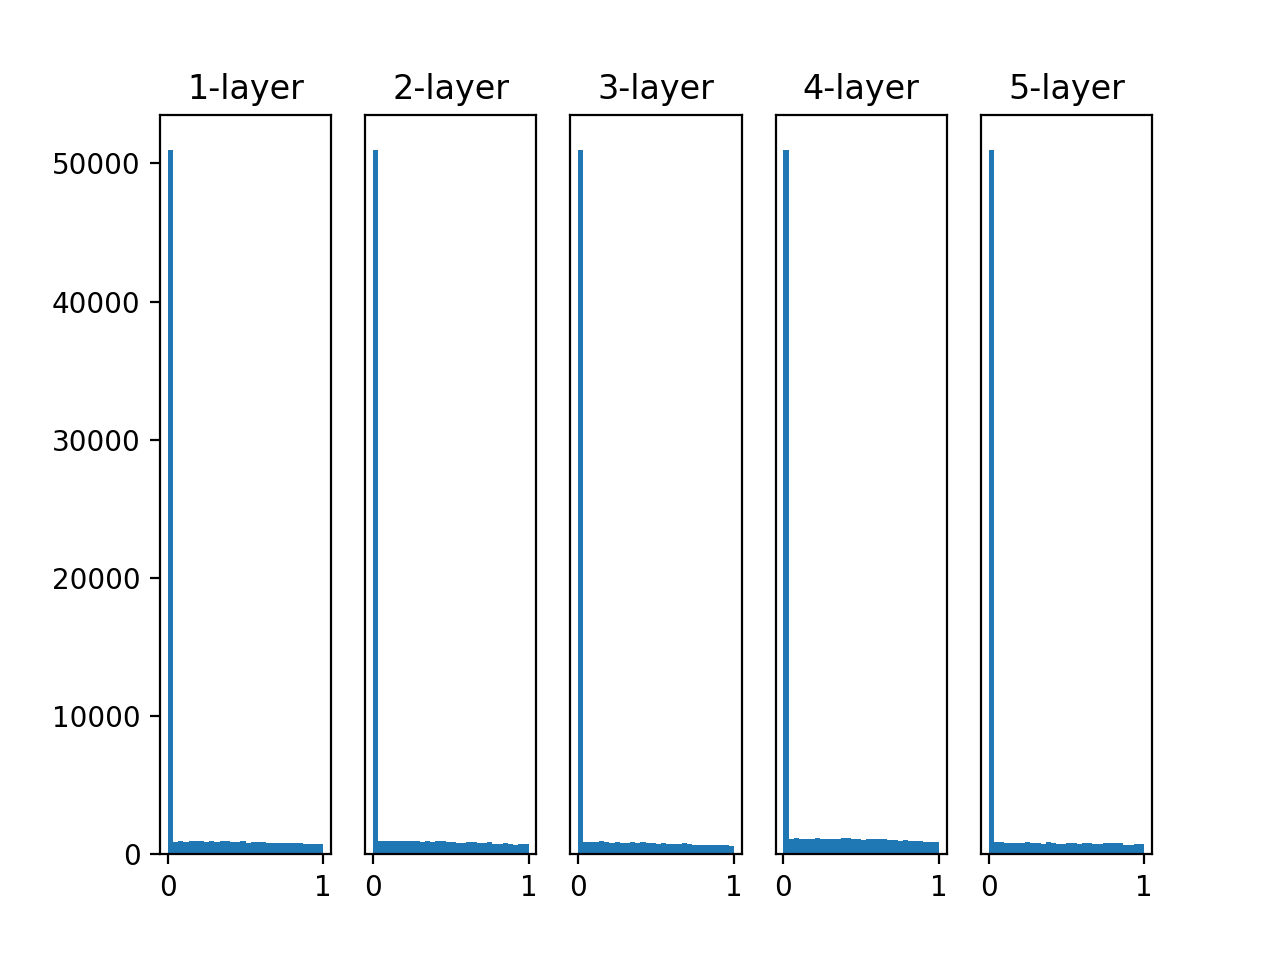

In [42]:
hidden_layer_activations(np.sqrt(2/100), 'ReLU')

### 6.2.4 MNISTデータセットによる重みの初期値の比較

In [25]:
###############################
# ch06/weight_init_compare.py #
###############################

# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

KeyboardInterrupt: 

## 6.3 Batch Normalization

強制的にアクティベーションの分布を調整する

### 6.3.1 Batch Normalization のアルゴリズム

ミニバッチごとに正規化（平均0,分散1）することで，データの分布の偏りを減らす．

* 学習を速く進む
* 初期値の依存性が低い
* 過学習を抑制

### 6.3.2 Batch Normalization の評価

In [ ]:
###########################
# ch06/batch_norm_test.py #
###########################

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


## 6.4 正則化

過学習を抑制し，汎化性能を持たせる．

### 6.4.1 過学習

過学習の起きる要因

* パラメータが多く，表現力が高い
* 訓練データが少ない

In [ ]:
################################
# ch06/overfit_weight_decay.py #
################################

# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


### 6.4.2 Weight decay

[【機械学習】LPノルムってなんだっけ？](http://qiita.com/kenmatsu4/items/cecb466437da33df2870)

### 6.4.3 Dropout

ニューラルネットワークにおいて，ニューロンをランダムに無効化（消去）しながら学習する手法．

アンサンブル学習と等価？

## 6.5 ハイパーパラメータの検証